In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate

In [2]:
os.environ["PATH"]='/home/manhducnmd/latex/bin/x86_64-linux'
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
#plt.rcParams['font.family'] = 'sans-serif'

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-28 12:46:36.487168: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-28 12:46:37.882191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-28 12:46:37.882421: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-28 12:46:37.883965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-28 12:46:37.885384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-28 12:46:37.885697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-28 12:46:37.887444: I tensorflow/stream_executor/platform/d

In [27]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [29]:
bkg_sr_jet_1 = np.load('background_images_sr_50_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_50_jet_2.npy')

signal_sr_jet_1 = np.load('dd10_sr_50_jet_1.npy')
signal_sr_jet_2 = np.load('dd10_sr_50_jet_2.npy')




In [30]:
print(np.shape(bkg_sr_jet_1), np.shape(signal_sr_jet_1))

(65859, 50, 50) (197943, 50, 50)


In [31]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],50,50,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],50,50,1))


In [32]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, channels, filters, kernel_size, trable = False, conv_trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', trainable=conv_trable)

        self.shift = self.add_weight(name='shift', shape=(filters), 
                                     initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(1, 1, channels, filters), 
                                     initializer='ones', trainable=True)
        self.trable = trable
        self.act = keras.activations.relu
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
            'act': self.act,
        })
        return config
    # Defines the computation
    def call(self, inputs):
        if self.trable == False:
            x = self.conv(inputs)
            x = self.act(x)
            return x
        else:
            y = self.conv(inputs)
            oldw = self.non_trainable_weights[0]
            oldb = self.non_trainable_weights[1]
            neww = tf.multiply(oldw, self.scale) 
            newb = tf.add(oldb, self.shift)
            x = tf.nn.conv2d(inputs, neww, strides = 1, padding='SAME') + newb            
            x = self.act(x)
            return x

In [33]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False, conv_trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        ConvScaleShift(1 , 64, (5,5), trable = trable, conv_trable = conv_trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, 128, (3,3), trable = trable, conv_trable = conv_trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [34]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [35]:
epsilon_s_full = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model = CWoLA(50, trable = True)
        loaded_model.load_weights(
            f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_mtl_dd10_{n_train_sr_signal}_50')
        x_predict = loaded_model.predict([x_test_1, x_test_2])
        fpr, tpr, th = roc_curve(y_test, x_predict)
        f = interpolate.interp1d(fpr, tpr)
        epsilon_s = f([0.001, 0.01, 0.1])
        epsilon_s_1.append(epsilon_s)
    epsilon_s_full.append(epsilon_s_1)
epsilon_s_full = np.array(epsilon_s_full)


        

50 0
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9


400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9


1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0
1200 1
1200 2
1200 3
1200 4
1200 5
1200 6


1200 7
1200 8
1200 9


In [36]:
mean_results = np.mean(epsilon_s_full, axis = 1)
std_results = np.std(epsilon_s_full, axis = 1)

In [38]:
epsilon_s_full_2 = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1_2 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model_2 = CWoLA(50, trable = True)
        loaded_model_2.load_weights(
            f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ft_dd10_{n_train_sr_signal}_50')
        #loaded_model_2 = keras.models.load_model(
            #f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_dd10_{n_train_sr_signal}_25.keras')
        x_predict_2 = loaded_model_2.predict([x_test_1, x_test_2])
        fpr_2, tpr_2, th_2 = roc_curve(y_test, x_predict_2)
        f_2 = interpolate.interp1d(fpr_2, tpr_2)
        epsilon_s_2 = f_2([0.001, 0.01, 0.1])
        epsilon_s_1_2.append(epsilon_s_2)
    epsilon_s_full_2.append(epsilon_s_1_2)
epsilon_s_full_2 = np.array(epsilon_s_full_2)


        

50 0
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1


500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0
1200 1
1200 2
1200 3
1200 4
1200 5
1200 6
1200 7
1200 8
1200 9


In [52]:
epsilon_s_full_3 = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1_3 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model_3 = CWoLA(50, trable = True)
        loaded_model_3.load_weights(
            f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ht_dd10_{n_train_sr_signal}_50')
        #loaded_model_2 = keras.models.load_model(
            #f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_dd10_{n_train_sr_signal}_25.keras')
        x_predict_3 = loaded_model_3.predict([x_test_1, x_test_2])
        fpr_3, tpr_3, th_3 = roc_curve(y_test, x_predict_3)
        f_3 = interpolate.interp1d(fpr_3, tpr_3)
        epsilon_s_3 = f_3([0.001, 0.01, 0.1])
        epsilon_s_1_3.append(epsilon_s_3)
    epsilon_s_full_3.append(epsilon_s_1_3)
epsilon_s_full_3 = np.array(epsilon_s_full_3)


        

50 0
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2


450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0
1200 1
1200 2
1200 3
1200 4
1200 5
1200 6
1200 7
1200 8
1200 9


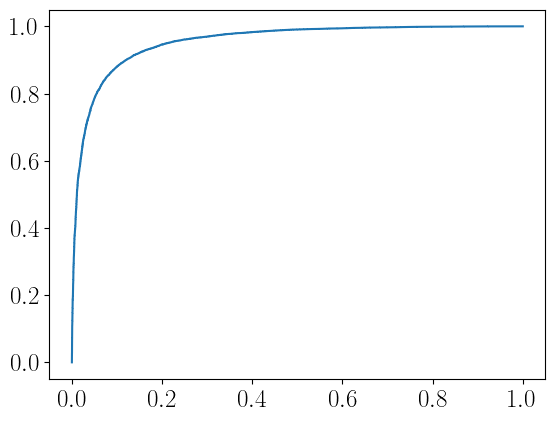

In [14]:
plt.plot(fpr_2, tpr_2)

In [39]:
mean_results_2 = np.mean(epsilon_s_full_2, axis = 1)
std_results_2 = np.std(epsilon_s_full_2, axis = 1)

In [53]:
mean_results_3 = np.mean(epsilon_s_full_3, axis = 1)
std_results_3 = np.std(epsilon_s_full_3, axis = 1)

In [40]:
print(np.shape(mean_results))

(17, 3)


In [41]:
print(np.shape(mean_results_2))

(17, 3)


In [54]:
print(np.shape(mean_results_3))

(17, 3)


In [42]:
print(mean_results)

[[0.022005   0.180505   0.585525  ]
 [0.04739    0.2556     0.6627325 ]
 [0.074825   0.343785   0.7508075 ]
 [0.14093    0.43447    0.8084975 ]
 [0.16406    0.473925   0.8319305 ]
 [0.1897     0.50326    0.84473429]
 [0.316585   0.62638    0.8899875 ]
 [0.224475   0.55331    0.87161917]
 [0.32041    0.63207    0.902915  ]
 [0.30663    0.63322    0.906917  ]
 [0.40195    0.709095   0.92604174]
 [0.420125   0.719345   0.93082405]
 [0.49279    0.76264    0.94568467]
 [0.49746    0.77056    0.94680145]
 [0.53777    0.794845   0.953693  ]
 [0.554305   0.81073833 0.9576994 ]
 [0.60577    0.837565   0.96472867]]


In [43]:
print(mean_results_2)

[[0.016895   0.13932667 0.48607   ]
 [0.03573    0.218205   0.59637   ]
 [0.075935   0.3072125  0.69573792]
 [0.11137    0.38167    0.7564975 ]
 [0.12709    0.403925   0.76430833]
 [0.190965   0.490395   0.82819   ]
 [0.264885   0.5683725  0.8591    ]
 [0.261025   0.57554    0.86464352]
 [0.31786    0.625135   0.89593917]
 [0.327545   0.638515   0.9017775 ]
 [0.41961    0.71293    0.92696775]
 [0.444105   0.73037    0.93338583]
 [0.425155   0.71313    0.92794667]
 [0.45932    0.7435225  0.93895933]
 [0.51443    0.78184    0.94770318]
 [0.511665   0.781415   0.950735  ]
 [0.54829    0.79763    0.9517545 ]]


In [55]:
print(mean_results_3)

[[0.03671    0.20453    0.57605   ]
 [0.0555     0.25545    0.670618  ]
 [0.080515   0.31613    0.71633   ]
 [0.12146    0.40111    0.79196917]
 [0.15038    0.44885    0.82714   ]
 [0.19768    0.5079     0.844425  ]
 [0.25612    0.56565    0.8736475 ]
 [0.24745    0.573455   0.8778465 ]
 [0.295655   0.602885   0.89292467]
 [0.37407    0.688075   0.92360431]
 [0.41869    0.71937    0.93094417]
 [0.38366    0.692615   0.92350833]
 [0.455955   0.74603    0.94273325]
 [0.46779    0.75868    0.9488121 ]
 [0.487705   0.762715   0.94529126]
 [0.48268    0.7727775  0.95153273]
 [0.521295   0.79373    0.95787875]]


In [44]:
from uncertainties import unumpy
array = unumpy.uarray(mean_results, std_results)
print(array)

[[0.022004999999999997+/-0.013544896640432513
  0.180505+/-0.056325466931042845 0.5855250000000001+/-0.0835572416071761]
 [0.04739+/-0.032519654057200545
  0.25560000000000005+/-0.08517903497927173
  0.6627325+/-0.09766366139076499]
 [0.074825+/-0.03590223008393768 0.343785+/-0.07679925797167575
  0.7508075+/-0.06592173015212816]
 [0.14093+/-0.08639805900597537 0.43446999999999997+/-0.09060041721758239
  0.8084975+/-0.04445969024014899]
 [0.16405999999999998+/-0.08452462303967999
  0.4739250000000001+/-0.10871051984513734
  0.8319305+/-0.04217907445938093]
 [0.18970000000000004+/-0.06154527601692919 0.50326+/-0.07034731622457249
  0.8447342857142857+/-0.036113354390116155]
 [0.31658500000000006+/-0.12688869738869574
  0.6263799999999999+/-0.1077227209088222
  0.8899874999999999+/-0.03806208620464726]
 [0.22447500000000004+/-0.07965831799002537 0.55331+/-0.07877120603367707
  0.8716191666666667+/-0.02864718088951627]
 [0.32041000000000003+/-0.10339119353213792 0.63207+/-0.07174249507788

In [45]:
array_2 = unumpy.uarray(mean_results_2, std_results_2)
print(array_2)

[[0.016895+/-0.010859568361587857
  0.13932666666666665+/-0.04409582822293586
  0.48607000000000006+/-0.07377879505657435]
 [0.03573+/-0.016756807571849715
  0.21820500000000004+/-0.061957850390406535
  0.5963700000000001+/-0.08194575934726579]
 [0.075935+/-0.04321577865780044 0.3072125+/-0.07812526259955867
  0.6957379166666666+/-0.05623103329771887]
 [0.11137000000000001+/-0.06411003119637364 0.38167+/-0.08285227878580047
  0.7564975+/-0.04869061312255165]
 [0.12708999999999998+/-0.06797431426649334
  0.403925+/-0.09762478745175326
  0.7643083333333334+/-0.051403251761602264]
 [0.19096500000000002+/-0.09421708191724047
  0.490395+/-0.09948338919136199 0.82819+/-0.043414961706766474]
 [0.264885+/-0.07749027051830443 0.5683725+/-0.07542480730005215
  0.8591000000000001+/-0.034928527023050965]
 [0.261025+/-0.08690815913940417 0.5755399999999999+/-0.08366656082330623
  0.8646435227272727+/-0.03446404239935658]
 [0.31786+/-0.09726650451208782 0.625135+/-0.06692755803852399
  0.89593916666

In [56]:
array_3 = unumpy.uarray(mean_results_3, std_results_3)
print(array_3)

[[0.03671+/-0.023327299457931258
  0.20453000000000002+/-0.06514258284716687
  0.5760499999999998+/-0.09340243840500097]
 [0.055499999999999994+/-0.05837900735709711
  0.25545000000000007+/-0.1051050141525132
  0.6706179999999999+/-0.09049636520877509]
 [0.08051499999999999+/-0.04358107416069503
  0.31612999999999997+/-0.07677188026875464
  0.7163299999999999+/-0.056174826212459256]
 [0.12145999999999997+/-0.05419043642562772
  0.40110999999999997+/-0.07119275876098637
  0.7919691666666667+/-0.04273245319718959]
 [0.15038+/-0.04978996485236759 0.44885+/-0.06166850492755602
  0.82714+/-0.031493854956165655]
 [0.19768+/-0.0737307778339548 0.5079+/-0.08991972531096835
  0.844425+/-0.0457261706307838]
 [0.25612+/-0.07956269603275143 0.56565+/-0.06029380979835326
  0.8736475+/-0.021073835821938055]
 [0.24745000000000003+/-0.07788571435122105
  0.573455+/-0.07696398329738398
  0.8778464999999999+/-0.028740451636152117]
 [0.295655+/-0.07684182601292085 0.602885+/-0.05767505981791437
  0.89292

In [46]:
x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200])
sig_before = np.sqrt(2*((x+25000)*np.log(x/25000 + 1) - x))
                     
sig_after_1 = unumpy.sqrt(2*((x*array[:,0]+25000*0.001)*unumpy.log(x*array[:, 0]/(25000*0.001) + 1)
                         -x*array[:,0]))
sig_after_2 = unumpy.sqrt(2*((x*array[:,1]+25000*0.01)*unumpy.log(x*array[:, 1]/(25000*0.01) + 1)
                         -x*array[:,1]))
sig_after_3 = unumpy.sqrt(2*((x*array[:,2]+25000*0.1)*unumpy.log(x*array[:, 2]/(25000*0.1) + 1)
                         -x*array[:,2]))


                     
                    
                      
                      

In [47]:
sig_after_1_std = []
sig_after_2_std = []
sig_after_3_std = []
sig_after_1_mean = []
sig_after_2_mean = []
sig_after_3_mean = []
sig_after_1_mean.append(0)
sig_after_2_mean.append(0)
sig_after_3_mean.append(0)
sig_after_1_std.append(0)
sig_after_2_std.append(0)
sig_after_3_std.append(0)

sig_before = np.append(0, sig_before)

for w, y, z in zip(sig_after_1, sig_after_2, sig_after_3):
    sig_after_1_mean.append(w.n)
    sig_after_1_std.append(w.s)
    
    sig_after_2_mean.append(y.n)
    sig_after_2_std.append(y.s)
    
    sig_after_3_mean.append(z.n)
    sig_after_3_std.append(z.s)
    

    
    

In [48]:
sig_after_1_2 = unumpy.sqrt(2*((x*array_2[:,0]+25000*0.001)*unumpy.log(x*array_2[:, 0]/(25000*0.001) + 1)
                         -x*array_2[:,0]))
sig_after_2_2 = unumpy.sqrt(2*((x*array_2[:,1]+25000*0.01)*unumpy.log(x*array_2[:, 1]/(25000*0.01) + 1)
                         -x*array_2[:,1]))
sig_after_3_2 = unumpy.sqrt(2*((x*array_2[:,2]+25000*0.1)*unumpy.log(x*array_2[:, 2]/(25000*0.1) + 1)
                         -x*array_2[:,2]))


                     
                    
                      
                      

In [49]:
sig_after_1_std_2 = []
sig_after_2_std_2 = []
sig_after_3_std_2 = []
sig_after_1_mean_2 = []
sig_after_2_mean_2 = []
sig_after_3_mean_2 = []
sig_after_1_mean_2.append(0)
sig_after_2_mean_2.append(0)
sig_after_3_mean_2.append(0)
sig_after_1_std_2.append(0)
sig_after_2_std_2.append(0)
sig_after_3_std_2.append(0)


for w, y, z in zip(sig_after_1_2, sig_after_2_2, sig_after_3_2):
    sig_after_1_mean_2.append(w.n)
    sig_after_1_std_2.append(w.s)
    
    sig_after_2_mean_2.append(y.n)
    sig_after_2_std_2.append(y.s)
    
    sig_after_3_mean_2.append(z.n)
    sig_after_3_std_2.append(z.s)
    

    
    

In [57]:
sig_after_1_3 = unumpy.sqrt(2*((x*array_3[:,0]+25000*0.001)*unumpy.log(x*array_3[:, 0]/(25000*0.001) + 1)
                         -x*array_3[:,0]))
sig_after_2_3 = unumpy.sqrt(2*((x*array_3[:,1]+25000*0.01)*unumpy.log(x*array_3[:, 1]/(25000*0.01) + 1)
                         -x*array_3[:,1]))
sig_after_3_3 = unumpy.sqrt(2*((x*array_3[:,2]+25000*0.1)*unumpy.log(x*array_3[:, 2]/(25000*0.1) + 1)
                         -x*array_3[:,2]))


                     
                    
                      
                      

In [58]:
sig_after_1_std_3 = []
sig_after_2_std_3 = []
sig_after_3_std_3 = []
sig_after_1_mean_3 = []
sig_after_2_mean_3 = []
sig_after_3_mean_3 = []
sig_after_1_mean_3.append(0)
sig_after_2_mean_3.append(0)
sig_after_3_mean_3.append(0)
sig_after_1_std_3.append(0)
sig_after_2_std_3.append(0)
sig_after_3_std_3.append(0)


for w, y, z in zip(sig_after_1_3, sig_after_2_3, sig_after_3_3):
    sig_after_1_mean_3.append(w.n)
    sig_after_1_std_3.append(w.s)
    
    sig_after_2_mean_3.append(y.n)
    sig_after_2_std_3.append(y.s)
    
    sig_after_3_mean_3.append(z.n)
    sig_after_3_std_3.append(z.s)
    

    
    

25x25 res

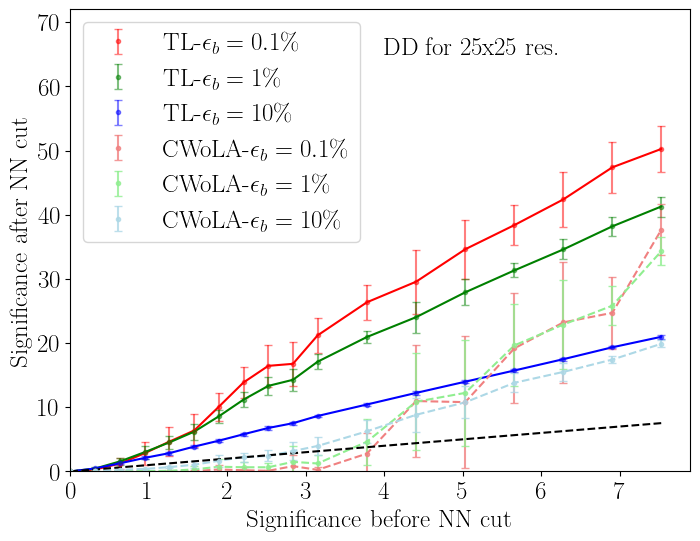

In [25]:
plt.figure(figsize=(8, 6))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'TL-$\epsilon_b = 0.1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'TL-$\epsilon_b = 1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'TL-$\epsilon_b = 10\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'CWoLA-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'CWoLA-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'CWoLA-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.text(4, 65, "DD for 25x25 res.")
plt.xlim(0, 7.9)
plt.ylim(0, 72)
plt.savefig('CWoLA vs TL - 25x25 res')
plt.show()

50x50 res

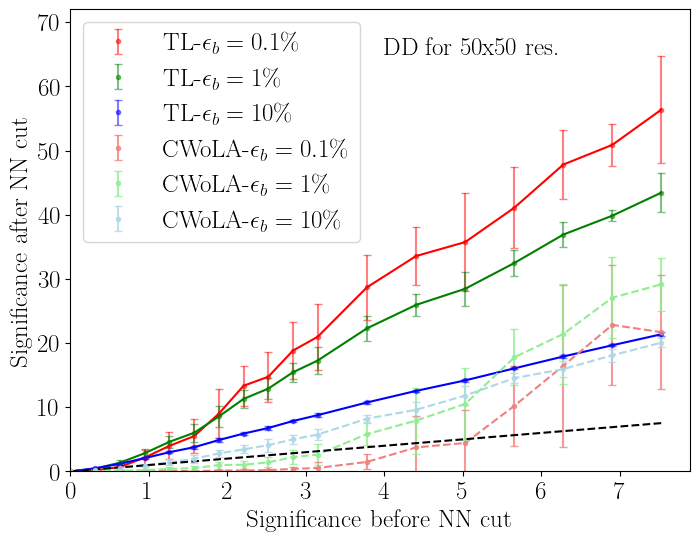

In [28]:
plt.figure(figsize=(8, 6))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'TL-$\epsilon_b = 0.1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'TL-$\epsilon_b = 1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'TL-$\epsilon_b = 10\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'CWoLA-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'CWoLA-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'CWoLA-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.text(4, 65, "DD for 50x50 res.")
plt.xlim(0, 7.9)
plt.ylim(0, 72)
plt.savefig('CWoLA vs TL - 50x50 res')
plt.show()


75x75 res

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'TL-$\epsilon_b = 0.1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'TL-$\epsilon_b = 1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'TL-$\epsilon_b = 10\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'CWoLA-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'CWoLA-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'CWoLA-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.text(4, 65, "DD for 75x75 res.")
plt.xlim(0, 7.9)
plt.ylim(0, 72)
plt.savefig('CWoLA vs TL - 75x75 res')
plt.show()


Meta transfer learning

50x50 res

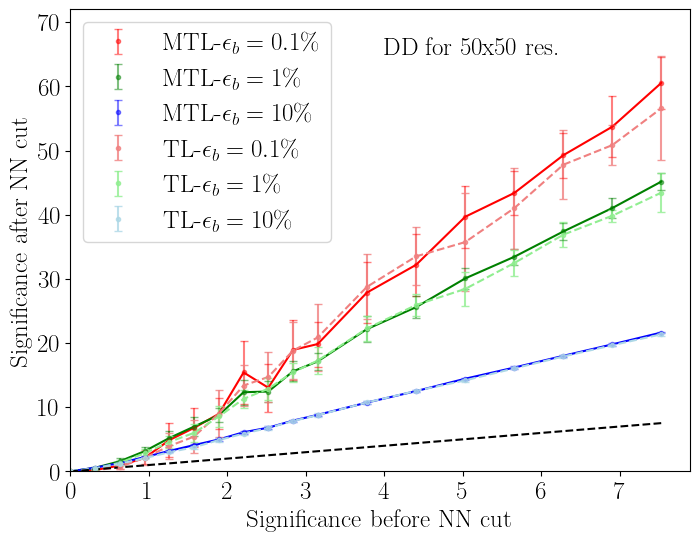

In [50]:
plt.figure(figsize=(8, 6))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'MTL-$\epsilon_b = 0.1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'MTL-$\epsilon_b = 1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'MTL-$\epsilon_b = 10\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'TL-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'TL-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'TL-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.text(4, 65, "DD for 50x50 res.")
plt.xlim(0, 7.9)
plt.ylim(0, 72)
plt.savefig('MTL vs TL - 50x50 res')
plt.show()


Hard task vs none 25x25

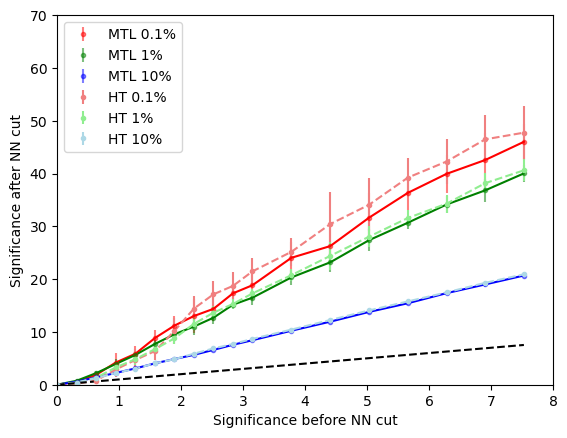

In [115]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'MTL $0.1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'MTL $1$%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'MTL $10$%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'HT $0.1$%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'HT $1$%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'HT $10$%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

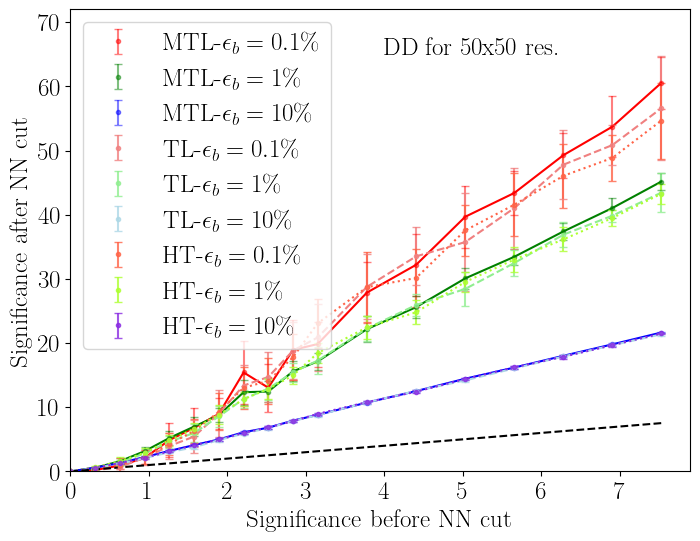

In [66]:
plt.figure(figsize=(8, 6))
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, 
             fmt = '.', c='r', label = 'MTL-$\epsilon_b = 0.1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, 
             fmt = '.', c = 'g', label = 'MTL-$\epsilon_b = 1\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, 
             fmt = '.', c = 'b', label = 'MTL-$\epsilon_b = 10\%$', alpha = 0.5, capsize = 3)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, 
             fmt = '.', c='lightcoral', label = 'TL-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, 
             fmt = '.', c = 'lightgreen', label = 'TL-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, 
             fmt = '.', c = 'lightblue', label = 'TL-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.errorbar(sig_before, sig_after_1_mean_3, yerr = sig_after_1_std_3, 
             fmt = '.', c='tomato', label = 'HT-$\epsilon_b = 0.1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_1_mean_3, c = 'tomato', ls = ':')

plt.errorbar(sig_before, sig_after_2_mean_3, yerr = sig_after_2_std_3, 
             fmt = '.', c='greenyellow', label = 'HT-$\epsilon_b = 1\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_2_mean_3, c = 'greenyellow', ls = ':')

plt.errorbar(sig_before, sig_after_3_mean_3, yerr = sig_after_3_std_3, 
             fmt = '.', c='blueviolet', label = 'HT-$\epsilon_b = 10\%$', alpha = 0.8, capsize = 3)
plt.plot(sig_before, sig_after_3_mean_3, c = 'blueviolet', ls = ':')

             

plt.plot(sig_before, sig_before, ls = '--', c = 'black')

plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.text(4, 65, "DD for 50x50 res.")
plt.xlim(0, 7.9)
plt.ylim(0, 72)
plt.savefig('MTL vs TL vs HT - 50x50 res')
plt.show()


In [75]:
print('Meta Transfer learning: \n', sig_after_1_mean, '\n', sig_after_2_mean, '\n', sig_after_3_mean)
print('Transfer learning: \n', sig_after_1_mean_2, '\n', sig_after_2_mean_2, '\n', sig_after_3_mean_2)
print('Hard task: \n', sig_after_1_mean_3, '\n', sig_after_2_mean_3, '\n', sig_after_3_mean_3)


Meta Transfer learning: 
 [0, 0.21846483006355022, 0.919999385225941, 2.102110788672412, 4.891858969547289, 6.794994028049846, 8.977338596352942, 15.428764185118247, 13.051911349234997, 18.937558069437475, 19.850247838080048, 27.870812277900875, 32.20240327185292, 39.69415614185338, 43.402374065974264, 49.28880350249856, 53.72541650733818, 60.538325146175254] 
 [0, 0.5674231313860398, 1.5901213425767493, 3.1579711657453844, 5.216125180287789, 6.994752298557278, 8.770668147805841, 12.34618773896737, 12.452742835828166, 15.594800580650716, 17.14620357822693, 22.176519903279164, 25.606963907223122, 30.087999118880134, 33.45447972227803, 37.40196695050637, 41.04872402076359, 45.165925580170466] 
 [0, 0.5843877418585456, 1.3196725601846189, 2.235820880313602, 3.2000349343733805, 4.10388864677231, 4.986202683520345, 6.106827131207964, 6.81962973558097, 7.91980662462147, 8.813858602034069, 10.73488222362444, 12.519324286986825, 14.450490797992273, 16.19041203806277, 18.02107113069681, 19.8015

In [73]:
print(sig_after_1_std, '\n', sig_after_2_std, '\n', sig_after_3_std)
print(sig_after_1_std_2, '\n', sig_after_2_std_2, '\n', sig_after_3_std_2)
print(sig_after_1_std_3, '\n', sig_after_2_std_3, '\n', sig_after_3_std_3)


[0, 0.13351487141654958, 0.6135737874562488, 0.9500416996074498, 2.666616901816874, 3.019646877091618, 2.440764500148451, 4.871335810977398, 3.7210636528015284, 4.6977063804948855, 3.500006926280692, 4.812609455161492, 4.783174458367871, 4.852412971195287, 3.4668972260770055, 3.4896477573379108, 4.78853997241468, 4.089141820456733] 
 [0, 0.17602047765178747, 0.5214512903511095, 0.6841000730190488, 1.0362779283269574, 1.507271155768771, 1.1368101939702415, 1.9227985136457721, 1.6043895888871125, 1.5728078587144965, 1.2914903440447791, 2.0059548839027452, 1.6987997454753943, 1.651007418325457, 1.2678577468238248, 1.3147992709667051, 1.5852708409651255, 1.331771590049475] 
 [0, 0.08323344270741477, 0.19362937504382124, 0.19487644795920528, 0.17415253155213933, 0.20533361146325044, 0.20979039035059677, 0.25615849256651196, 0.2193663927627077, 0.1566453251408145, 0.15560424874049375, 0.21883850459187226, 0.14369484542913666, 0.16089735380475736, 0.2154651086851707, 0.14357480426950864, 0.28

50x50

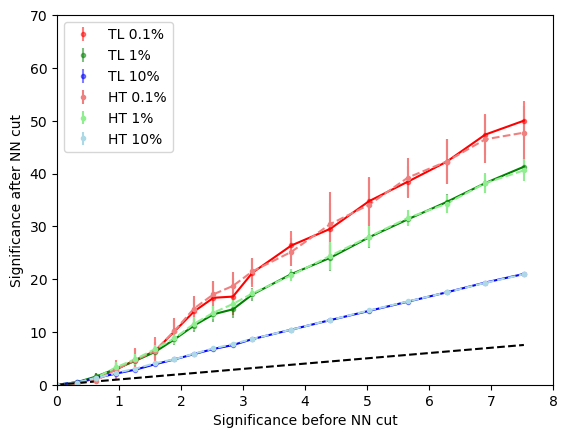

In [128]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'TL 0.1%', alpha = 0.5)
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'TL 1%', alpha = 0.5)
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'TL 10%', alpha = 0.5)
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='lightcoral', label = 'HT 0.1%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'lightcoral', ls = '--')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'lightgreen', label = 'HT 1%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'lightgreen', ls = '--')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'lightblue', label = 'HT 10%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'lightblue', ls = '--')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper left')
plt.xlim(0, 8)
plt.ylim(0, 70)
plt.show()

In [133]:
print(sig_after_1_mean)
print(sig_after_1_mean_2)

[0, 0.29805328884086496, 1.2307793226847288, 2.849855939779427, 4.692389469327477, 6.378709443870646, 10.092420156578992, 13.86965733802547, 16.4632410394271, 16.692972125628454, 21.217590899766098, 26.3751404673273, 29.524258741835393, 34.76379421723542, 38.45909355455159, 42.22893199631615, 47.372787437190894, 50.00865278475393]
[0, 0.21595103645226196, 0.7920533941842527, 2.887617557451105, 4.691611149339081, 6.367634925804574, 10.192644829894812, 14.422228123679398, 17.125585738353244, 18.715280626253985, 21.46888739450683, 25.16775516943062, 30.42496661261538, 34.085677374194304, 39.22566288993811, 42.275313642918846, 46.47662725319519, 47.73836032131675]


In [91]:
print(sig_after_1_mean)
print(sig_after_1_mean_2)

[0, 0.5391936829214466, 1.8814741594187798, 4.20629386900737, 5.855390525861374, 8.842028456721597, 11.194343072600146, 13.013352705066131, 14.369177660109859, 17.310230489444727, 18.84107945984573, 24.03941303119999, 26.255753185775827, 31.63882249140575, 36.338348907571266, 39.93903100432255, 42.56525143330692, 46.001262519299274]
[0, 0.29805328884086496, 1.2307793226847288, 2.849855939779427, 4.692389469327477, 6.378709443870646, 10.092420156578992, 13.86965733802547, 16.4632410394271, 16.692972125628454, 21.217590899766098, 26.3751404673273, 29.524258741835393, 34.76379421723542, 38.45909355455159, 42.22893199631615, 47.372787437190894, 50.00865278475393]


In [63]:
loaded_model = keras.models.load_model('ft_run_9_id10_1000_25.keras')
x_predict = loaded_model.predict([x_test_1, x_test_2])


In [64]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


In [65]:
fpr, tpr, th = roc_curve(y_test, x_predict)

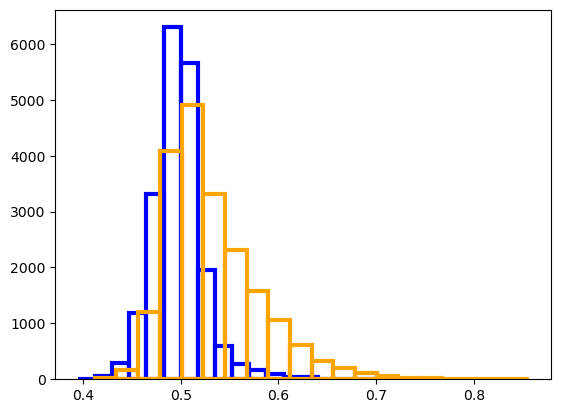

In [66]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


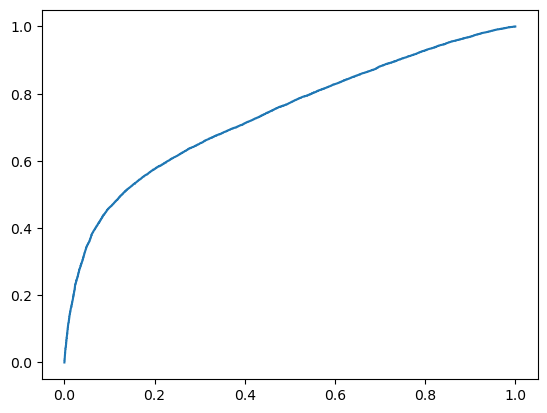

0.7374694162499998


In [67]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))

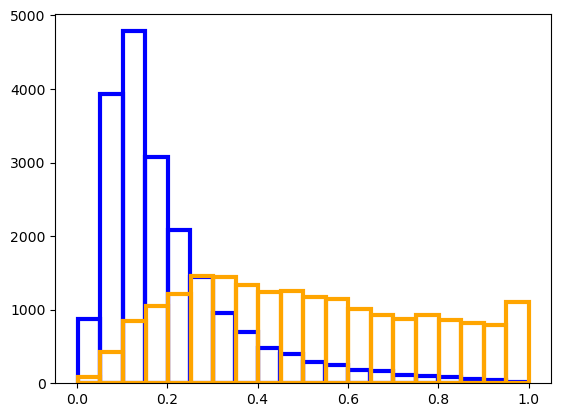

In [55]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


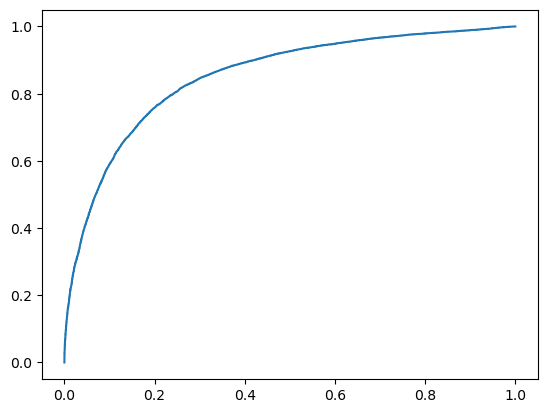

0.8516413599999999


In [62]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))